# Twitter Sentiment Analysis

## Connect to Twitter API

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
##!pip install python-twitter
import twitter
import pandas as pd

API_KEY = "4QlG7dBQ1UeHAXyk1pC6n7LTm"
API_KEY_SECRET = "td6zhDHTI795WKXGYjXBJUwba9xCyxZ3o73VYro9XtLrQD30UZ"
ACCESS_TOKEN = "1067118225744371712-8rjdKc3f2rFNf7FXczj5T3X1W6yfu4"
ACCESS_TOKEN_SECRET = "Hw1A7nii1S2JAh0hMgkR6xZB1IddC1KAgJBPI5OaoQnSv"

# initialize api instance
twitter_api = twitter.Api(consumer_key=API_KEY,
                  consumer_secret=API_KEY_SECRET,
                  access_token_key=ACCESS_TOKEN,
                  access_token_secret=ACCESS_TOKEN_SECRET)

# test authentication
print(twitter_api.VerifyCredentials())

{"created_at": "Mon Nov 26 18:09:45 +0000 2018", "default_profile": true, "default_profile_image": true, "friends_count": 2, "id": 1067118225744371712, "id_str": "1067118225744371712", "name": "EliskaKloberdanz", "profile_background_color": "F5F8FA", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "EliskaKloberda1"}


## Search Twitter for any key word for which you want to analyze sentiment

In [3]:
# serach tweets by key words
def buildTestSet(search_keyword):
    text = []
    try:
        tweets_fetched = twitter_api.GetSearch(search_keyword, count=100)
        print("Fetched " + str(len(tweets_fetched)) + " tweets for the term " + search_keyword)
        for status in tweets_fetched:
            text.append(status.text)
        return pd.DataFrame({'tweet_text': text})
        #return [{"text":status.text, "label":None} for status in tweets_fetched]
    except:
        print("Unfortunately, something went wrong..")
        return None

In [4]:
search_term = input("Enter a search keyword: ")
testDataSet = buildTestSet(search_term)

print(testDataSet[0:4])

Enter a search keyword: oil
Fetched 100 tweets for the term oil
                                          tweet_text
0  The President of Tanzania was suspicious of th...
1  Speaker Pelosi supports push for taxpayer bail...
2  Palm oil is in pretty much everything. This is...
3  RT @steve_hanke: .@Pemex is killing, not savin...


## Build Train Set or Upload if Train Set Exists

In [5]:
import os.path
from os import path
import pandas as pd
import csv
import time 

def downloadTweetText(corpusFile):
    corpus = pd.read_csv(corpusFile)
    corpus.columns = ['', 'topic', 'label', 'tweet_id']
    corpus = corpus.drop(corpus.columns[0], axis=1)
    rate_limit=180
    sleep_time=900/180
    
    training_tweets_text =[]

    for tweet in corpus['tweet_id']:
        try:
            status = twitter_api.GetStatus(tweet)
            print("Tweet fetched" + status.text)
            training_tweets_text.append(status.text)
            #time.sleep(sleep_time)
        except: 
            training_tweets_text.append('NaN')
            continue
    print("Finished scraping")
    return training_tweets_text

if path.exists("trainingData.csv"):
    # upload train set
    trainingData = pd.read_csv('trainingData.csv')
else:
    # create train set
    corpusFile = 'labeled_corpus.csv'
    trainingDataTweetText = downloadTweetText(corpusFile)
    trainingData = pd.read_csv(corpusFile)
    trainingData['tweet_text'] = trainingDataTweetText
    corpus.columns = ['', 'topic', 'label', 'tweet_id', 'tweet_text']
    trainingData.to_csv('trainingData.csv')
    

## Data Pre-processing

In [6]:
# Drop NaNs
trainingData = trainingData[trainingData['tweet_text'].isnull() == False]

# Unique Labels
trainingData['label'].unique()

# Encode Labels
trainingData.loc[trainingData.label == 'neutral', 'label'] = 0
trainingData.loc[trainingData.label == 'irrelevant', 'label'] = 2
trainingData.loc[trainingData.label == 'positive','label'] = 1
trainingData.loc[trainingData.label == 'negative', 'label'] = -1

# Check dirstibution of labels
trainingData.groupby('label').size()


label
-1    253
 0    248
 1    116
dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

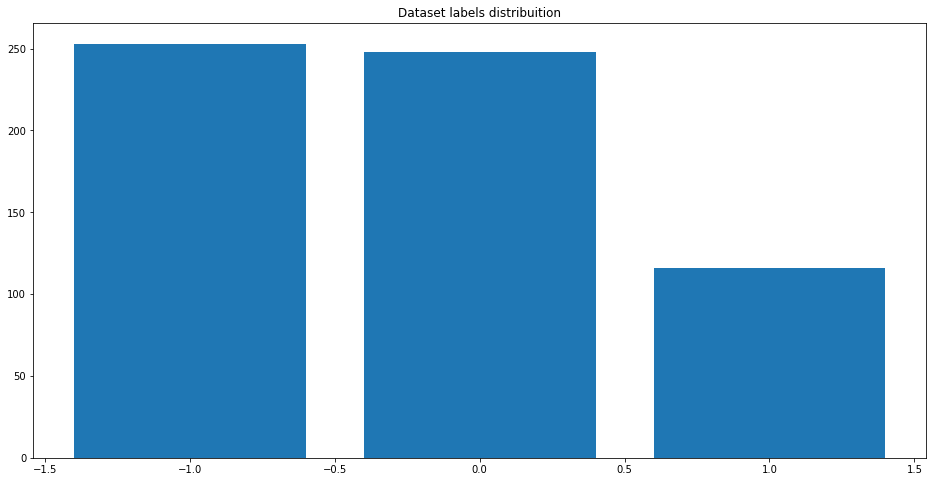

In [7]:
# Dataset label distribution
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
target_cnt = Counter(trainingData.label)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [8]:
trainingData.head(5)

,topic,label,tweet_id,tweet_text
1,apple,1,1.264028e+17,Hilarious @youtube video - guy does a duet wit...
2,apple,1,1.263972e+17,@RIM you made it too easy for me to switch to ...
5,apple,1,1.263797e+17,The 16 strangest things Siri has said so far. ...
6,apple,1,1.263777e+17,Great up close & personal event @Apple tonight...
7,apple,1,1.263738e+17,From which companies do you experience the bes...


In [9]:
import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
import re

def preprocess_Text(data):
    words = set(nltk.corpus.words.words())
    for row in data.index:
        text = data.loc[row, 'tweet_text']
        text = text.lower()
        text = " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words and w.isalpha()) #remove non-english words
        text = re.sub('<[^<]+?>', '', text) #remove html tags
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) #remove links
        text = text.strip('=')
        text = text.split(" ") 
        text = [w for w in text if w not in nltk.corpus.stopwords.words('english')]
        lem = nltk.stem.WordNetLemmatizer()
        text = [lem.lemmatize(i) for i in text]
        text = ' '.join(str(e) for e in text)
        data.loc[row,'tweet_text'] = text #replace description in place in the dataframe
        row += 1
    return data

[nltk_data] Downloading package words to /home/eliska/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /home/eliska/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eliska/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Pre-process the training set so that it is balanced

smallest_Category = trainingData.groupby('label').size().min()

data_0 = trainingData.loc[trainingData['label'] == 0].head(smallest_Category)
data_1 = trainingData.loc[trainingData['label'] == 1].head(smallest_Category)
data_neg_1 = trainingData.loc[trainingData['label'] == -1].head(smallest_Category)

balanced_Data = pd.concat([data_0, data_1, data_neg_1])

In [11]:
trainingData = preprocess_Text(balanced_Data)
trainingData.head(5)

,topic,label,tweet_id,tweet_text
567,apple,0,1.264175e+17,would watched apple jihad adobe flash consider...
569,apple,0,1.264156e+17,hey apple brand new state art new phone come
570,apple,0,1.264147e+17,apple record quarter bunch professional aka di...
572,apple,0,1.264100e+17,interesting read war b w apple latter agree la...
573,apple,0,1.264080e+17,apple earnings call even apple need new releas...


In [12]:
testingData = preprocess_Text(testDataSet)
testingData.head(5)

,tweet_text
0,president suspicious testing trick investigate
1,speaker push taxpayer corporate morning propos...
2,palm oil pretty much everything cheap
3,killing saving slash oil production despite
4,difference h oil


## Vectorization

In [13]:
from sklearn.feature_extraction.text import CountVectorizer # Count vector
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF

list_of_vectorizors = [CountVectorizer(), TfidfVectorizer()]

## Split data intro train and test sets

In [14]:
# Split data into traning and testing
split_ratio = 0.7
total_number_of_datapoints = len(trainingData.index)
train_number_of_datapoints = int(total_number_of_datapoints * split_ratio)

from sklearn.utils import shuffle
trainingData = shuffle(trainingData)

train_set = trainingData.iloc[:train_number_of_datapoints, :]
test_set = trainingData.iloc[train_number_of_datapoints:, :]



## Model

In [39]:
def model(clf, vectorizer):
    #  Train the classifier
    vectorizer.fit_transform(list(trainingData['tweet_text']))
    vectors_train = vectorizer.transform(list(train_set['tweet_text']))
    clf.fit(vectors_train, train_set['label'].values)

    # Get the test vectors
    vectors_test = vectorizer.transform(list(test_set['tweet_text']))

    # Predict and score the vectors
    from sklearn import metrics
    pred = clf.predict(vectors_test)
    acc_score = metrics.accuracy_score( test_set['label'].values, pred)
    f1_score = metrics.f1_score( test_set['label'].values, pred, average='macro')
#     print('\nModel type: {}'.format(clf))
#     print('Vectorization type: {}'.format(vectorizer))
#     print('Total accuracy classification score: {}'.format(acc_score))
#     print('Total F1 classification score: {}'.format(f1_score))
#     print('--------------------------------------------------------------------------------')
    return clf, acc_score

# Build the classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

list_of_models = [MultinomialNB(alpha=.01), tree.DecisionTreeClassifier(), RandomForestClassifier(), 
                  AdaBoostClassifier(), LogisticRegression(), 
                  KNeighborsClassifier(), SVC(), MLPClassifier()]

results = pd.DataFrame(columns = ['model_type', 'vectorization_type', 'accuracy'])

results_acc = []
results_vect = []
results_models = []


best_acc = 0
for model_type in list_of_models:
    for vectorizer in list_of_vectorizors:
        clf = model(model_type, vectorizer)[0]
        acc = model(model_type, vectorizer)[1]
        
        if acc > best_acc:
            best_model = clf
            best_acc = acc
        
        results_acc.append(model(model_type, vectorizer)[1])
        results_vect.append(vectorizer)
        results_models.append(model_type)

data = {'model_type': results_models, 'vectorization_type': results_vect, 'accuracy': results_acc}
results = pd.DataFrame(data, columns = ['model_type', 'vectorization_type', 'accuracy'])

### Results for different model types and vectorization techniques

In [37]:
results.sort_values(by=['accuracy'], ascending=False)

,model_type,vectorization_type,accuracy
9,"LogisticRegression(C=1.0, class_weight=None, d...","TfidfVectorizer(analyzer='word', binary=False,...",0.561905
11,"KNeighborsClassifier(algorithm='auto', leaf_si...","TfidfVectorizer(analyzer='word', binary=False,...",0.561905
2,"DecisionTreeClassifier(class_weight=None, crit...","CountVectorizer(analyzer='word', binary=False,...",0.542857
8,"LogisticRegression(C=1.0, class_weight=None, d...","CountVectorizer(analyzer='word', binary=False,...",0.533333
0,"MultinomialNB(alpha=0.01, class_prior=None, fi...","CountVectorizer(analyzer='word', binary=False,...",0.514286
5,"(DecisionTreeClassifier(class_weight=None, cri...","TfidfVectorizer(analyzer='word', binary=False,...",0.514286
14,"MLPClassifier(activation='relu', alpha=0.0001,...","CountVectorizer(analyzer='word', binary=False,...",0.514286
15,"MLPClassifier(activation='relu', alpha=0.0001,...","TfidfVectorizer(analyzer='word', binary=False,...",0.514286
4,"(DecisionTreeClassifier(class_weight=None, cri...","CountVectorizer(analyzer='word', binary=False,...",0.504762
1,"MultinomialNB(alpha=0.01, class_prior=None, fi...","TfidfVectorizer(analyzer='word', binary=False,...",0.485714


### Best Model

In [40]:
best_model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Apply best model

In [41]:
# Get the test vectors
vectors_test = vectorizer.transform(list(testDataSet['tweet_text']))
pred = best_model.predict(vectors_test)

In [42]:
testDataSet['label'] = pred

In [43]:
# Decode Labels
testDataSet.loc[testDataSet.label == 0, 'label'] = 'neutral'
testDataSet.loc[testDataSet.label == 2, 'label'] = 'irrelevant'
testDataSet.loc[testDataSet.label == 1,'label'] = 'positive'
testDataSet.loc[testDataSet.label == -1, 'label'] = 'negative'

In [44]:
testDataSet.head(6)

,tweet_text,label
0,president suspicious testing trick investigate,negative
1,speaker push taxpayer corporate morning propos...,negative
2,palm oil pretty much everything cheap,negative
3,killing saving slash oil production despite,negative
4,difference h oil,negative
5,tweet got thinking remember oil bust someone m...,positive
